<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Custom_Training_Fashion_Mnist_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

In [2]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True)
test_data = tfds.load("fashion_mnist", split = "test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete7S16X7/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete7S16X7/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
def format_image(data):
  image = data["image"]
  image = tf.reshape(image,[-1])
  image = tf.cast(image, tf.float32)
  image /= 255
  return image, data["label"]

In [5]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [7]:
batch_size = 64
train = train_data.shuffle(buffer_size = 1024).batch(batch_size)
test = test_data.batch(batch_size)

# Define the Model

In [48]:
def base_model():
  # 784 = 28 * 28
  inputs = tf.keras.layers.Input(shape = (784,),name = 'digits')
  x = tf.keras.layers.Dense(64,activation = 'relu',name = 'dense_1')(inputs)
  x = tf.keras.layers.Dense(64,activation = 'relu',name = 'dense_2')(x)
  outputs = tf.keras.layers.Dense(10,activation = 'softmax',name = 'predictions')(x)
  model = tf.keras.Model(inputs = inputs,outputs = outputs)
  return model

# Define Optimizer and Loss function

In [58]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Define Metrics

In [59]:
train_acc_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metrics = tf.keras.metrics.SparseCategoricalAccuracy()

# Building Training Loop

In [60]:
def apply_gradient(optimizer,model,x,y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true = y,y_pred = logits)

  gradients = tape.gradient(loss_value,model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights))

  return logits,loss_value

In [61]:
def train_data_for_one_epoch():
  losses = []
  # l_bar : represents the left part of the progress bar. It includes the progress information and any text you want to display before the actual progress bar itself.
  # |: This is a separator
  # n_fmt : current iterations
  # total_fmt : total interations
  pbar = tqdm(total = len(list(enumerate(train))),position = 0, leave = True, bar_format = '{l_bar}{bar} | {n_fmt}/{total_fmt}')
  for step,(x_batch_train,y_batch_train) in enumerate(train):
    logits,loss_value = apply_gradient(optimizer,model,x_batch_train,y_batch_train)
    losses.append(loss_value)

    train_acc_metrics(y_batch_train,logits)
    pbar.set_description("Training loss for step %s: %.4f" % (int(step),float(loss_value)))
    pbar.update()

  return losses

In [62]:
def perform_validation():
  losses = []
  for x_val,y_val in test:
    val_logits = model(x_val)
    val_loss = loss_object(y_true = y_val,y_pred = val_logits)

    losses.append(val_loss)
    val_acc_metrics(y_val,val_logits)

  return losses

In [66]:
model = base_model()

# Iterate over epochs
epochs = 10
epochs_val_losses,epochs_train_losses = [],[]
for epoch in range(epochs):
  print("Start of epoch %d" % (epoch,))

  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metrics.result()

  losses_val = perform_validation()
  val_acc = val_acc_metrics.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_train_losses.append(losses_train_mean)
  epochs_val_losses.append(losses_val_mean)

  print("Epoch : %s, Train loss : %.4f, Validation loss : %.4f, Train Accuracy : %.4f, Validation Accuracy : %.4f\n"
       % (epoch,float(losses_train_mean),float(losses_val_mean),float(train_acc),float(val_acc)))

  train_acc_metrics.reset_states()
  val_acc_metrics.reset_states()

Start of epoch 0


Training loss for step 937: 0.3971: 100%|██████████ | 938/938


Epoch : 0, Train loss : 0.4807, Validation loss : 0.4255, Train Accuracy : 0.8330, Validation Accuracy : 0.8486

Start of epoch 1


Training loss for step 937: 0.5703: 100%|██████████ | 938/938


Epoch : 1, Train loss : 0.3658, Validation loss : 0.3837, Train Accuracy : 0.8657, Validation Accuracy : 0.8629

Start of epoch 2


Training loss for step 937: 0.4783: 100%|██████████ | 938/938


Epoch : 2, Train loss : 0.3349, Validation loss : 0.3625, Train Accuracy : 0.8765, Validation Accuracy : 0.8713

Start of epoch 3


Training loss for step 937: 0.2339: 100%|██████████ | 938/938


Epoch : 3, Train loss : 0.3161, Validation loss : 0.3606, Train Accuracy : 0.8842, Validation Accuracy : 0.8687

Start of epoch 4


Training loss for step 937: 0.2859: 100%|██████████ | 938/938


Epoch : 4, Train loss : 0.2989, Validation loss : 0.3567, Train Accuracy : 0.8898, Validation Accuracy : 0.8707

Start of epoch 5


Training loss for step 937: 0.1180: 100%|██████████ | 938/938


Epoch : 5, Train loss : 0.2884, Validation loss : 0.3430, Train Accuracy : 0.8939, Validation Accuracy : 0.8747

Start of epoch 6


Training loss for step 937: 0.3000: 100%|██████████ | 938/938


Epoch : 6, Train loss : 0.2774, Validation loss : 0.3464, Train Accuracy : 0.8956, Validation Accuracy : 0.8756

Start of epoch 7


Training loss for step 937: 0.1648: 100%|██████████ | 938/938


Epoch : 7, Train loss : 0.2692, Validation loss : 0.3473, Train Accuracy : 0.9004, Validation Accuracy : 0.8773

Start of epoch 8


Training loss for step 937: 0.1335: 100%|██████████ | 938/938


Epoch : 8, Train loss : 0.2596, Validation loss : 0.3498, Train Accuracy : 0.9032, Validation Accuracy : 0.8774

Start of epoch 9


  0%|           | 0/938
  0%|           | 0/938
  0%|           | 0/938
  0%|           | 0/938
  0%|           | 0/938
  0%|           | 0/938
  0%|          | 0/938 
  0%|          | 0/938 
  0%|           | 0/938
  0%|           | 0/938
Training loss for step 937: 0.2535: 100%|██████████ | 938/938


Epoch : 9, Train loss : 0.2510, Validation loss : 0.3376, Train Accuracy : 0.9059, Validation Accuracy : 0.8828



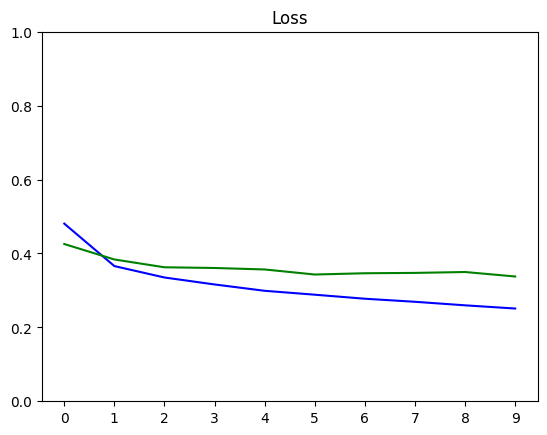

In [67]:
def plot_metrics(train_metric,val_metric,metric_name,title,ylim = 5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color = 'blue',label = metric_name)
  plt.plot(val_metric,color = 'green',label = "val" + metric_name)

plot_metrics(epochs_train_losses,epochs_val_losses,'Loss','Loss',ylim = 1.0)

In [68]:
# Utility to dislay a row of imnages with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)]

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

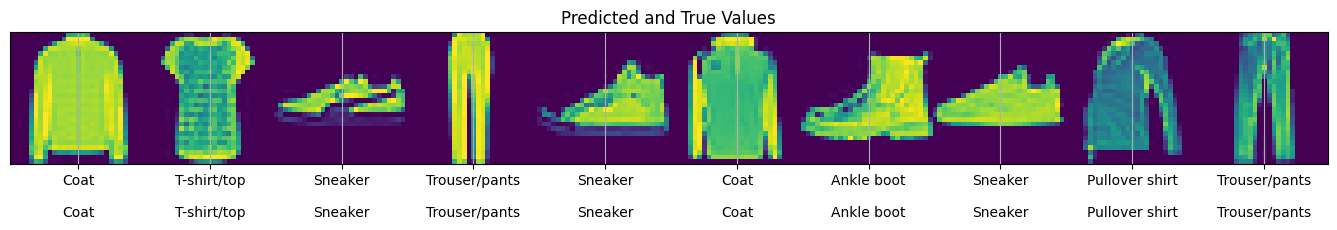

In [69]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)